In [36]:
# for data analysis
import pandas as pd
import numpy as np


#For data Modeling
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


#For NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#Miscellaneous

# for progress  bars
from tqdm import tqdm

#regular expressions
import re

#for .pkl file
import joblib

### Reading the data

In [2]:
data = pd.read_csv("mbti.csv") 
data.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [3]:
#Visualizing one of the post columns
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

### Data Cleaning and lemmatization
This function effectively preprocesses the text data by converting it to lowercase, removing URLs, and removing symbols and special characters. The result is a list of cleaned sentences along with the length of each sentence. This can be useful for further analysis or modeling tasks.

Steps: 
It initializes an empty list called data_length to store the length of each sentence (in terms of the number of words).

It creates an instance of the WordNetLemmatizer from the NLTK library. The WordNetLemmatizer is a tool for lemmatizing words (reducing words to their base or root form) in English.

It initializes an empty list called cleaned_text to store the processed text data after cleaning.

It loops through each sentence in the data.posts column of the input dataset (assuming the data object is a pandas DataFrame).

Inside the loop, it converts the sentence to lowercase using the lower() method to ensure uniformity in the text.

It removes links from the text data by using the re.sub() method to replace any URL with a space.

It removes symbols and special characters from the text data by using the re.sub() method with a regular expression that matches any character that is not a digit or lowercase letter and replaces it with a space.

It calculates the number of words in each cleaned sentence and appends that count to the data_length list.
It appends the cleaned sentence to the cleaned_text list.

Finally, it returns two lists: cleaned_text, which contains the cleaned sentences, and data_length, which contains the length of each sentence (in terms of the number of words).

In [4]:
#Function for cleaning the data and Lemmatization
def clean_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
# for removing url
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
# for removing non-numerical and non-alphaebtical chars, regex removes anything that isn't 0-9,a-z
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

### Splitting Data into train and test sets

We will use Stratify Split in splitting the data, it means that the split will be performed in a way that preserves the proportion of each unique value in the type column. It ensures that the training and test sets will have similar distributions of personality types, which is important to prevent imbalanced class distributions and potential bias in the model.

In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=69,stratify=data.type)

In [6]:
train_data

,type,posts
3467,INTP,'I am only sadistic towards other sadistic peo...
1426,INTP,"'Ideally, I shouldn't use the word god, I shou..."
739,ENTP,'Pretty much every relationship I've ever had ...
5316,ISFP,I was registered here a while ago and kinda fa...
510,INTP,'I like to play rogues! If I can add an ext...
...,...,...
5232,INTJ,'Because I liked that picture :3 Kittens are ...
5187,ENFP,'I confess that i focus too much on how others...
2342,INTP,'Wow! This is really good advice. However we a...
3888,ISTP,"'Ya I guess I'm pretty similar, if I'm with a ..."


In [7]:
test_data

,type,posts
4073,INFJ,'Yoda|||We haven't been cooked long enough.......
6558,INFJ,"'For being too polite.|||In essence, such a re..."
2732,ENTP,"Interesting, you've gone from Se dominant to N..."
6345,ISTP,'I've been told I have a death glare. My wife...
314,ENTP,'It happens to me. I feel compelled to help p...
...,...,...
2600,INFP,'All of you guys saying Just cut them out of y...
668,INFP,'So... My boyfriend died of an OD three days a...
1530,INTJ,'Rio Roberts Boo Newport Sid Vicious Wilson No...
8252,ENTJ,"'yes and no... I mean, I don't need my friends..."


In [8]:
# Cleaning and lemmatizing the train and test sets

In [9]:
train_data.posts,train_length=clean_text(train_data)

100%|█████████████████████████████████████| 6940/6940 [00:04<00:00, 1415.87it/s]


In [10]:
test_data.posts,test_length=clean_text(test_data)


100%|█████████████████████████████████████| 1735/1735 [00:01<00:00, 1408.16it/s]


In [11]:
print("This is how an entry in the new posts column looks")
print("__________________________________________________________________________________________________________")

train_data.posts[0]

This is how an entry in the new posts column looks
__________________________________________________________________________________________________________


'   and intj moments     sportscenter not top ten plays     pranks   what has been the most life changing experience in your life           on repeat for most of today    may the perc experience immerse you    the last thing my infj friend posted on his facebook before committing suicide the next day  rest in peace      enfj7  sorry to hear of your distress  it s only natural for a relationship to not be perfection all the time in every moment of existence  try to figure the hard times as times of growth  as      84389  84390             welcome and stuff       game  set  match    prozac  wellbrutin  at least thirty minutes of moving your legs  and i don t mean moving them while sitting in your same desk chair   weed in moderation  maybe try edibles as a healthier alternative      basically come up with three items you ve determined that each type  or whichever types you want to do  would more than likely use  given each types  cognitive functions and whatnot  when left by      all thi

### Creating a custom lemmatizer
#### The purpose of this custom Lemmatizer class is to provide a specialized tokenizer for the TfidfVectorizer from scikit-learn. By passing an instance of this class as the tokenizer parameter to TfidfVectorizer, it will be used to tokenize and lemmatize the text data during the vectorization process.

In [12]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

### Tokenisation

Why Tokenization was needed here:
> Tokenization is necessary to separate each word, as most NLP tasks, like sentiment analysis or language modeling, rely on analyzing individual words or word sequences

>Tokenization helps with text normalization, making it easier to apply further preprocessing steps like converting words to lowercase, removing stop words (commonly occurring words like "the," "is," "and"), and lemmatization (reducing words to their base or root form).

> Tokenization allows you to convert the text into a numerical representation, which is essential for many NLP tasks.

> Tokenization enables various forms of text analysis, such as counting the occurrence of words or calculating the frequency of different words.

>Tokenization reduces the overall vocabulary size, which is helpful in handling large datasets and improving the efficiency of NLP models.



#### TFIDF

Now we use TfidfVectorizer to create a term frequency-inverse document frequency (TF-IDF) representation of the text data in the train_data.posts column
>TfidfVectorizer : converts a collection of raw documents (text) into a numerical matrix representing the TF-IDF features.

>max_features : It limits the vocabulary size to (given value) which are the most important words based on their TF-IDF scores. Setting this parameter can help control the dimensionality of the TF-IDF matrix and prevent overfitting

>stop_words='english' : specifies that common English stop words (e.g., "the," "is," "and") should be removed during tokenization

>tokenizer=Lemmatizer() : This parameter sets the tokenizer for the vectorizer. The value here refers to the custom tokenizer function defined above that performs lemmatization on the text. Lemmatization reduces words to their base or root form, which can help in consolidating different word forms into one token (e.g., "running" and "runs" becoming "run").

> vectorizer.fit(train_data.posts): This line fits the TfidfVectorizer to the text data in the train_data.posts column. During the fitting process, the vectorizer tokenizes the text, removes stop words, and calculates the TF-IDF scores for each word in the vocabulary based on its occurrence frequency in the corpus(large and structured set of machine-readable texts)

In [13]:
#vectorizer
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x7fe1ba1d7430>)

#### Visualizing the  feature names extracted from the TfidfVectorizer

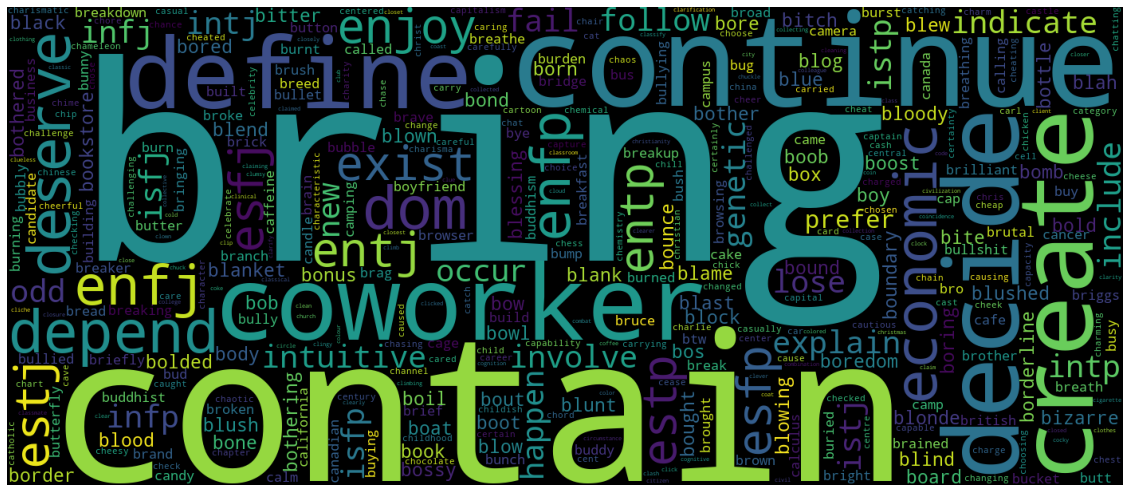

In [14]:
feature_names=vectorizer.get_feature_names_out()
wc=WordCloud(max_words=400, width=1400, height=600, collocations=False, background_color="black", colormap="viridis")

# generates the word cloud from the feature names. 
# It first selects a subset of feature names by slicing the feature_names array from index 500 to 3500. 
# It then joins these feature names into a single string separated by spaces
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

Why we are using tranformation?

The transform method converts the text data into a numerical representation using the TF-IDF (Term Frequency-Inverse Document Frequency) algorithm. It calculates the TF-IDF scores for each word in the vocabulary based on its occurrence frequency in each post and across all posts in the training dataset. The transform method returns a sparse matrix representation of the TF-IDF features.

These numerical feature vectors can be used as input to various machine learning models for tasks like text classification, sentiment analysis, or any other NLP-related tasks.


In [15]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [16]:
train_post

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07138999, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04697635]])

In [17]:
test_post

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.09546593,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Trasforming the personality type labels

The purpose of using LabelEncoder is to convert categorical labels (e.g., personality types such as "INFP") into numerical labels (e.g., 0, 1, 2, etc.), as most machine learning algorithms expect input data to be in numerical format. The LabelEncoder assigns a unique integer to each unique category in the target column, allowing the machine learning model to work with the target variable in a supervised learning task (e.g., classification).

The fit_transform() method fits the encoder to the unique classes in the target column (train_data.type) and then transforms the categorical labels into integers.

In [18]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [19]:
encoded_labels = target_encoder.fit_transform(train_data.type)

# Get the mapping between encoded labels and original labels
label_mapping = dict(zip(encoded_labels, train_data.type))

print(label_mapping)

{11: 'INTP', 3: 'ENTP', 13: 'ISFP', 10: 'INTJ', 8: 'INFJ', 9: 'INFP', 1: 'ENFP', 15: 'ISTP', 4: 'ESFJ', 2: 'ENTJ', 14: 'ISTJ', 0: 'ENFJ', 12: 'ISFJ', 7: 'ESTP', 6: 'ESTJ', 5: 'ESFP'}


In [20]:
train_target

array([11, 11,  3, ..., 11, 15,  9])

In [21]:
models_accuracy={}


#### Models


#### XGBoost

Why XGBoost?

>XGBoost can handle text data effectively by converting it into numerical representations through techniques like TF-IDF or word embeddings

> XGBoost uses an ensemble of decision trees to make predictions, so intricate patterns can be captured

>As data is high dimensional, regularization is required, it supports L1 and L2 regularization

> efficient and scalable

> Can handle imbalance in class


In [22]:
model_xgb=XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1)
model_xgb.fit(train_post,train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [23]:
print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.91      0.95       152
        ENFP       0.94      0.91      0.93       540
        ENTJ       0.98      0.94      0.96       185
        ENTP       0.92      0.91      0.91       548
        ESFJ       1.00      0.88      0.94        33
        ESFP       1.00      0.92      0.96        38
        ESTJ       1.00      0.87      0.93        31
        ESTP       1.00      0.94      0.97        71
        INFJ       0.92      0.91      0.91      1176
        INFP       0.89      0.94      0.91      1466
        INTJ       0.93      0.92      0.92       873
        INTP       0.90      0.91      0.91      1043
        ISFJ       1.00      0.95      0.98       133
        ISFP       0.98      0.92      0.95       217
        ISTJ       0.98      0.94      0.96       164
        ISTP       0.97      0.96      0.97       270

    accuracy                           0.92      

In [24]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

#### Naive Bayes (Multinomial)

Why Naive Bayes?

> Uses probabilistic approach. This probabilistic approach is well-aligned with the nature of text data, where the frequency of words plays a critical role in determining the class.

> NLP tasks often involve working with text data, and one common representation is the bag-of-words model or its extension, the term frequency-inverse document frequency (TF-IDF) representation. Multinomial Naive Bayes can handle these representations efficiently by modeling the probabilities of word occurrences.

> Handles Multiclass Classification: Multinomial Naive Bayes can handle multiclass classification problems where there are more than two classes to predict


In [25]:
#Training

In [26]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [27]:
print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.95      0.04      0.07       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.77      0.07      0.12       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.57      1176
        INFP       0.36      0.95      0.52      1466
        INTJ       0.80      0.43      0.56       873
        INTP       0.59      0.63      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       0.00      0.00      0.00       270

    accuracy                           0.46      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

In [28]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

Why Logistic Regression?

>Logistic Regression is a linear model that works well with text data represented as bag-of-words or TF-IDF features. It can handle high-dimensional feature spaces efficiently, which is common in NLP tasks with large vocabularies

> Logistic Regression provides interpretable results, as the coefficients associated with each feature indicate the impact of that feature on the probability of the positive class.

> Regularization

In [29]:
# Logistic Regression

In [30]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [31]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.93      0.16      0.28       152
        ENFP       0.79      0.64      0.71       540
        ENTJ       0.94      0.26      0.41       185
        ENTP       0.81      0.64      0.71       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.06      0.11        71
        INFJ       0.73      0.83      0.78      1176
        INFP       0.65      0.93      0.76      1466
        INTJ       0.72      0.80      0.76       873
        INTP       0.70      0.87      0.78      1043
        ISFJ       0.88      0.21      0.34       133
        ISFP       0.83      0.25      0.39       217
        ISTJ       0.80      0.27      0.41       164
        ISTP       0.87      0.50      0.63       270

    accuracy                           0.72      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))


In [33]:
#Accuracy comparison

In [34]:
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,XGBoost Classifier,0.668588
1,Multinomial Naive Bayes,0.381556
2,logistic regression,0.631124


In [37]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [38]:

ml_model = XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1)

ml_model.fit(train_post,train_target)
# Save the model to a file named ml_model.pkl
joblib.dump(ml_model, "ml_model.pkl")

['ml_model.pkl']

In [39]:
# Load the saved model
ml_model = joblib.load("ml_model.pkl")

# Load the TF-IDF vectorizer
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Preprocess the random text
random_text = "The sad truth is that there are no great “social networks” right now.We may fail, as so many have predicted, but we will try our best to make there be at least one."


text_features = tfidf_vectorizer.transform([random_text])

# Make predictions
ml_prediction = ml_model.predict(text_features)
print("Predicted personality type:", ml_prediction[0])

Predicted personality type: 9


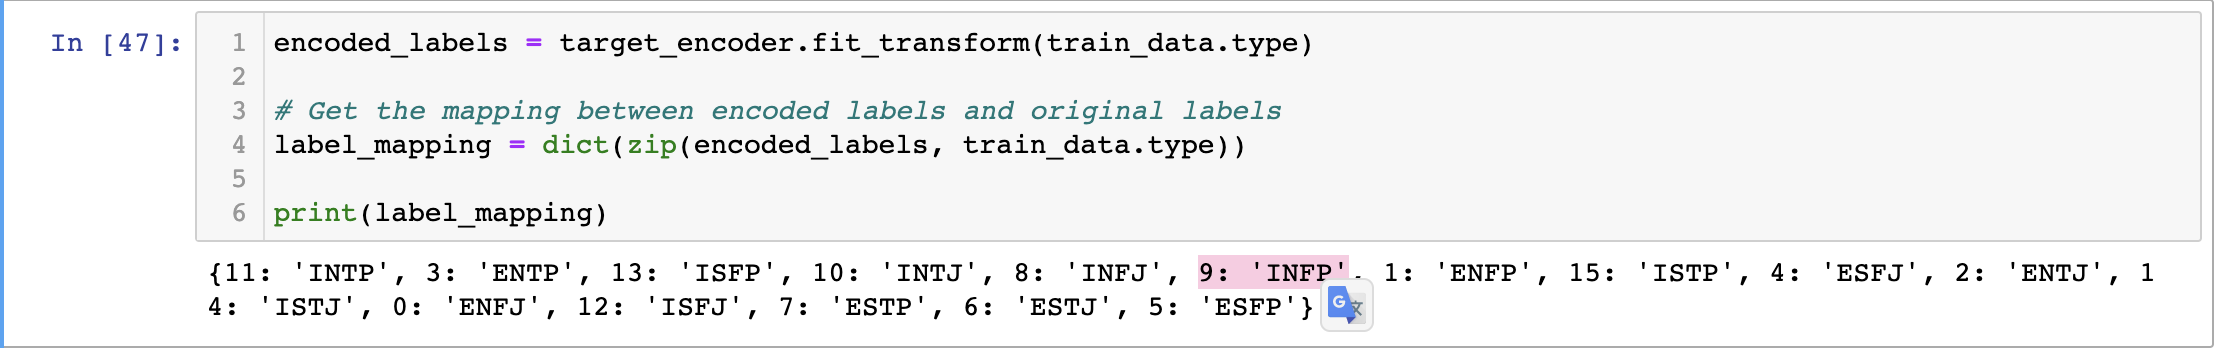
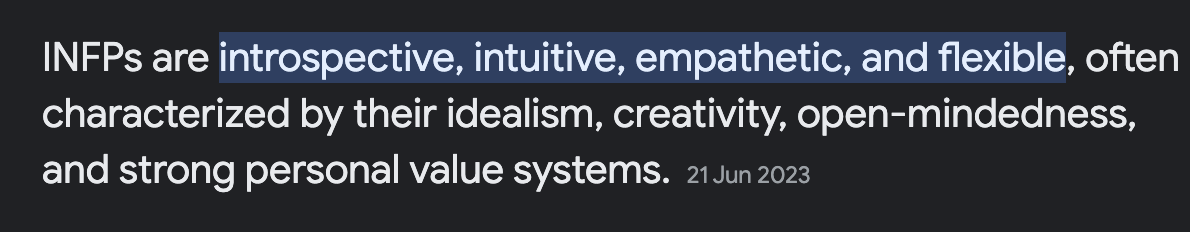